In [182]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from matplotlib import colors
import matplotlib as mpl
import functools
import argparse

In [183]:
def convex_hull_graham(points):
    '''
    Returns points on convex hull in CCW order according to Graham's scan algorithm.
    By Tom Switzer <thomas.switzer@gmail.com>.
    '''
    TURN_LEFT, TURN_RIGHT, TURN_NONE = (1, -1, 0)

    def cmp(a, b):
        return (a > b) - (a < b)

    def turn(p, q, r):
        return cmp((q[0] - p[0])*(r[1] - p[1]) - (r[0] - p[0])*(q[1] - p[1]), 0)

    def _keep_left(hull, r):
        while len(hull) > 1 and turn(hull[-2], hull[-1], r) != TURN_LEFT:
            hull.pop()
        if not len(hull) or hull[-1] != r:
            hull.append(r)
        return hull

    points = sorted(points)
    l = functools.reduce(_keep_left, points, [])
    u = functools.reduce(_keep_left, reversed(points), [])
    return l.extend(u[i] for i in range(1, len(u) - 1)) or l


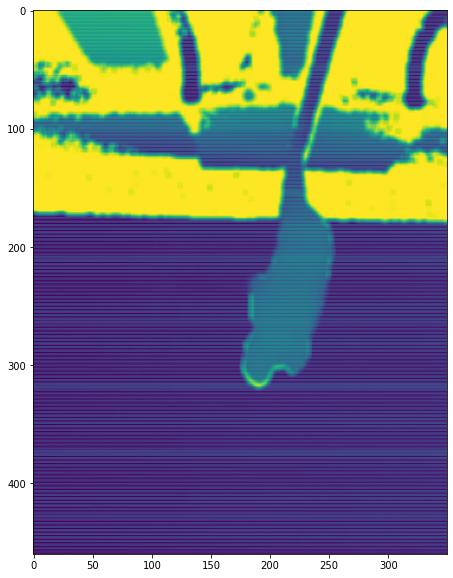

In [184]:
namefile = '../img/2/2.jpg'
namefile = './data/dm2.png'
namefile = '../data/map/clouds_tof/cloud_0_0071.jpg'

img = cv.imread(namefile)
img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)[70:420, 90:550]
img=cv.blur(img, (5,5))
img = img.transpose()
plt.figure(figsize=(10,10))
plt.imshow(img)

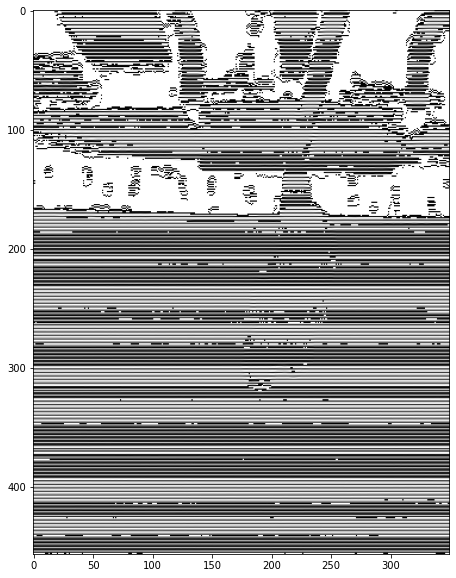

In [185]:
im1 = np.diff(img, axis=0, n=3)
plt.figure(figsize=(10,10))
plt.imshow(im1, cmap='gray_r')

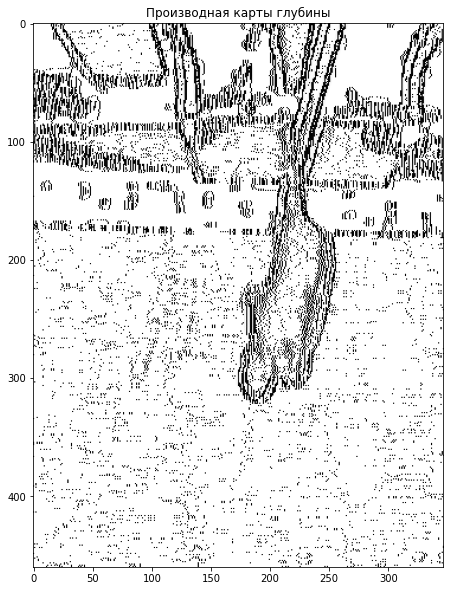

In [186]:
im2 = np.diff(img, axis=1, n=3)
plt.figure(figsize=(10,10))
plt.title('Производная карты глубины')
plt.imshow(im2, cmap='gray_r')

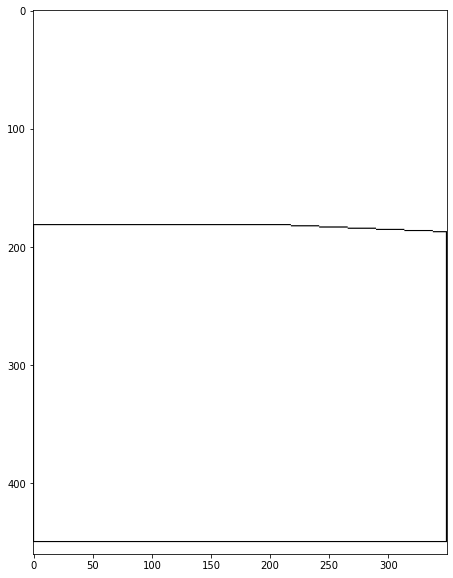

In [187]:
point_pol = img[400,50]
blanck = np.zeros(img.shape)
mask_loc_max = cv.inRange(img,np.array([point_pol-2], dtype=int),np.array([point_pol+10], dtype=int))
contours_niz, _ = cv.findContours(mask_loc_max, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

m=[]
points = []
for i, c in enumerate(contours_niz):
    if cv.contourArea(c)>100:
        m.append(i)


for ind in m:
    cnt = contours_niz[ind]
    points += cnt.squeeze(axis=1).tolist()
    # cv.drawContours(blanck,contours_niz,ind,1,1)


uncnt = convex_hull_graham(points)
#
niz = np.expand_dims(np.array(uncnt), axis=1) # как контур

cv.drawContours(blanck,[niz],0,1,1)

plt.figure(figsize=(10,10))
plt.imshow(blanck, cmap='gray_r')


<Figure size 720x720 with 0 Axes>

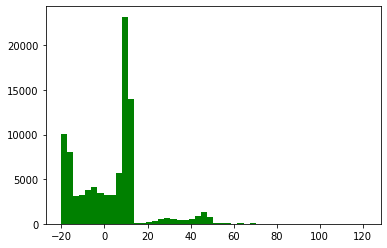

<Figure size 720x720 with 0 Axes>

In [188]:
r_xy = []
l_xy = []
r_z = []
l_z = []
dist = []
dist_arr = np.zeros((img.shape))


nach_perona_top = min([x[1] for x in points])+10
nach_perona_niz = max([x[1] for x in points])-10
nach_perona_left = min([x[0] for x in points])+10
nach_perona_right = max([x[0] for x in points])-10
H,W = img.shape

for y in range(nach_perona_top, nach_perona_niz, 10):
    for x in range(nach_perona_left, nach_perona_left + int(W * 0.1), 10):
        l_z.append(img[y, x])
        l_xy.append([x, y])
        cv.circle(blanck,(x,y),1,1,1)

    for x in range(nach_perona_right-int(W * 0.1), nach_perona_right, 10):
        r_z.append(img[y, x])
        r_xy.append([x, y])
        cv.circle(blanck,(x,y),1,1,1)

linear_regression = LinearRegression()
X = np.array(r_xy + l_xy)
Y = np.array(r_z + l_z)
linear_regression.fit(X, Y.reshape(-1, 1))

blanck = np.zeros(img.shape)

for x in range(0, W, 1):
    for y in range(0, H, 1):
        if cv.pointPolygonTest(niz, (x, y), False) == 1:
            # cv.circle(blanck,(x,y),1,1,1)
            delta = img[y, x] - linear_regression.predict(np.array([[x, y]]))[0, 0]
            dist.append(delta)
            dist_arr[y, x] = delta

plt.hist(dist, 50, color='g')

plt.figure(figsize=(10,10))
# plt.imshow(blanck, cmap='gray_r')

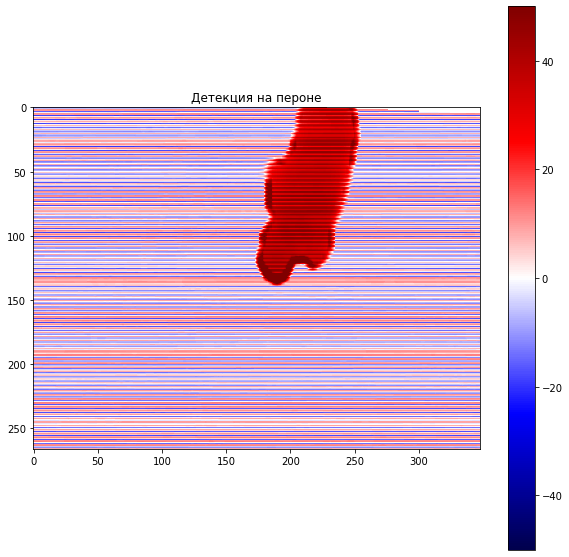

In [189]:
plt.figure(figsize=(10,10))
dist_arr = dist_arr[~np.all(dist_arr == 0, axis=1)]
dist_arr = dist_arr.transpose()
dist_arr = dist_arr[~np.all(dist_arr == 0, axis=1)]
dist_arr = dist_arr.transpose()
dist_arr[dist_arr == 0] = np.nan
# dist_arr[dist_arr < 0] = 0

norm = mpl.colors.Normalize(vmin=-50, vmax=50)


plt.imshow(dist_arr, cmap='seismic', norm=norm)
plt.colorbar()
plt.title('Детекция на пероне')
plt.show()



4


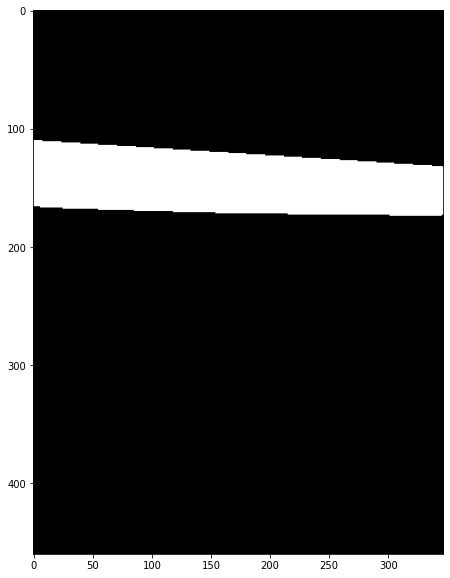

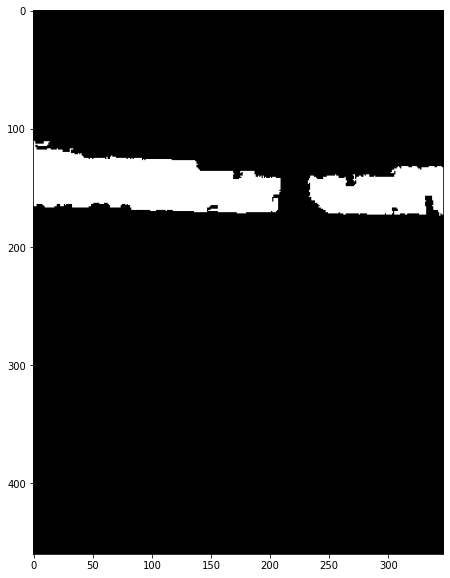

In [180]:
contours, _ = cv.findContours(im1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
blank = np.ones(im2.shape, dtype=np.uint8)
blank2 = np.zeros(im2.shape, dtype=np.uint8)
m = []
for i, c in enumerate(contours):
    if cv.contourArea(c)>1000:
        m.append(i)
leftpoints = []
rightpoints = []

for ind in m:
    cnt = contours[ind]
    cv.drawContours(blank,contours,ind,0,-1)

# new_blanck = 1 - blank

contours, _ = cv.findContours(blank, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
m = []
for i, c in enumerate(contours):
    if cv.contourArea(c)>1000:
        m.append(i)

print(len(m))

maxPoint = 0

blank = np.zeros(im2.shape, dtype=np.uint8)
for ind in m:
    cnt = contours[ind]
    maxPoint = max(maxPoint, max([line[1] for line in cnt.squeeze(axis=1).tolist()]))


points = []
for ind in m:
    cnt = contours[ind]
    nizc = max([line[1] for line in cnt.squeeze(axis=1).tolist()])
    if nizc > maxPoint - 50:
        cv.drawContours(blank2,contours,ind,1,-1)
        points += cnt.squeeze(axis=1).tolist()

uncnt = convex_hull_graham(points)

min_niz = min(y for x,y in uncnt)
niz = np.expand_dims(np.array(uncnt), axis=1) # как контур
cv.drawContours(blank,[niz],0,1,-1)

plt.figure(figsize=(10,10))
plt.imshow(blank, cmap='gray')

plt.figure(figsize=(10,10))
plt.imshow(blank2, cmap='gray')


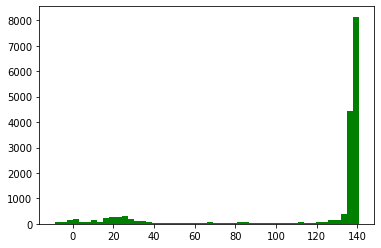

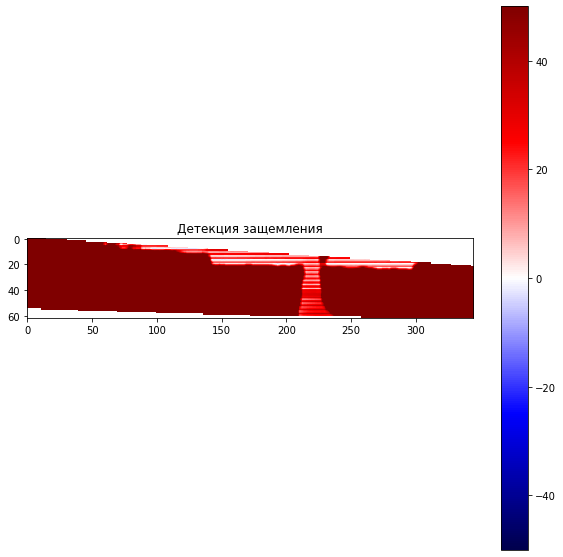

In [178]:
dist = []
dist_arr = np.zeros((img.shape))

for x in range(0, W, 1):
    for y in range(0, H, 1):
        if cv.pointPolygonTest(niz, (x, y), False) == 1:
            delta = img[y, x]- linear_regression.predict(np.array([[x, y]]))[0, 0]
            dist.append(delta)
            dist_arr[y, x] = delta

plt.hist(dist, 50, color='g')
plt.show()

plt.figure(figsize=(10,10))
dist_arr = dist_arr[~np.all(dist_arr == 0, axis=1)]
dist_arr = dist_arr.transpose()
dist_arr = dist_arr[~np.all(dist_arr == 0, axis=1)]
dist_arr = dist_arr.transpose()
dist_arr[dist_arr == 0] = np.nan



plt.imshow(dist_arr, cmap='seismic', norm=norm)
plt.colorbar()
plt.title('Детекция защемления')
plt.show()